<a href="https://colab.research.google.com/github/ScientistLim/ProjectAW/blob/feature%2Ftft-model-Hyun/tft_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
!pip install pytorch-forecasting
!pip instsall

ERROR: unknown command "instsall" - maybe you meant "install"


In [35]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [36]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import datetime  # datetime 모듈 임포트
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import torch
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import RMSE
from pytorch_lightning import Trainer, LightningModule
from pytorch_lightning.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from pytorch_forecasting.models.temporal_fusion_transformer.sub_modules import VariableSelectionNetwork
from torch import nn
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score


In [37]:
file_path = '/content/drive/MyDrive/종설프1_5팀/전처리.ipynb/[final] four-cycle-16months.xlsx'
df = pd.read_excel(file_path)

In [38]:
# 데이터 확인
print(df.head())

                 Time  feed_pressure
0 2023-06-16 13:30:00       9.050625
1 2023-06-16 13:40:00       9.051000
2 2023-06-16 13:50:00       9.051374
3 2023-06-16 14:00:00       9.051749
4 2023-06-16 14:10:00       9.052123


In [39]:
# 데이터 전처리: 필요한 컬럼 설정 (Time, feed_pressure)
df['time'] = pd.to_datetime(df['Time'])
df['time_idx'] = ((df['time'] - df['time'].min()).dt.total_seconds() // 60).astype(int)  # 5분 간격의 시간 인덱스 생성
df['group'] = "feed_pressure"  # 그룹화 컬럼 추가

# 데이터 길이 확인
total_length = len(df)
print(f"Total data length: {total_length} rows")

Total data length: 71488 rows


### 데이터 준비 및 설정
우선 max_encoder_length와 max_prediction_length를 설정하여 데이터의 인코더 및 예측 길이를 정의합니다.

In [86]:
# max_encoder_length와 max_prediction_length 설정
max_encoder_length = 1000
max_prediction_length = 100
min_encoder_length = 100

print(f"Max encoder length: {max_encoder_length} entries")
print(f"Max prediction length: {max_prediction_length} entries")
print(f"Min_encoder_length: {min_encoder_length} entries")

Max encoder length: 1000 entries
Max prediction length: 100 entries
Min_encoder_length: 100 entries


In [87]:
# 전체 데이터를 4개의 반복 패턴으로 나누기 (16주씩 4번 반복)
cycle_length = len(df) // 4

# 각 패턴을 데이터셋으로 나누기
train_data = pd.concat([df.iloc[:cycle_length * 3]])  # 처음 3개의 반복 패턴을 훈련 데이터로 사용
val_data = df.iloc[cycle_length * 3:]  # 마지막 반복 패턴을 검증 데이터로 사용

### TimeSeriesDataSet 생성
TimeSeriesDataSet을 사용해 데이터를 생성합니다. 여기에는 타겟, 그룹화 방식, 그리고 변동하는 시계열 컬럼을 정의합니다.


In [88]:
normalizer = GroupNormalizer(groups=["group"], transformation="softplus")

# 학습용 및 검증용 TimeSeriesDataSet 생성
training = TimeSeriesDataSet(
    train_data,
    time_idx="time_idx",
    target="feed_pressure",
    group_ids=["group"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    min_encoder_length=min_encoder_length,
    time_varying_unknown_reals=["feed_pressure"],
    time_varying_known_reals=["time_idx"],
    target_normalizer=normalizer,
    allow_missing_timesteps=True
)

validation = TimeSeriesDataSet(
    val_data,
    time_idx="time_idx",
    target="feed_pressure",
    group_ids=["group"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    min_encoder_length=min_encoder_length,
    time_varying_unknown_reals=["feed_pressure"],
    time_varying_known_reals=["time_idx"],
    target_normalizer=normalizer,
    allow_missing_timesteps=True
)

# normalizer 매개변수 출력
normalizer_stats = normalizer.get_parameters(groups=df["group"])
print(f"Normalizer parameters (mean, std): {normalizer_stats}")

Normalizer parameters (mean, std): [13.74567639  2.36048209]


### DataLoader 생성
DataLoader를 생성하여 모델이 데이터를 학습할 수 있도록 준비합니다.

In [90]:
# DataLoader 생성
batch_size = 16
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, shuffle=False, num_workers=0)

# Validation DataLoader 생성
val_dataloader = training.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

### Temporal Fusion Transformer 모델 생성
Temporal Fusion Transformer 모델을 생성하여 데이터셋을 학습할 준비를 합니다.

In [91]:
# Temporal Fusion Transformer 모델 생성
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.005,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=16,
    loss=RMSE(),
    log_interval=10,
    reduce_on_plateau_patience=3,
)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_forecasting/models/temporal_fusion_transformer/__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless of whether pytorch_optimizer is installed, in order to minimize the number of 

### LightningModule 정의 및 Trainer 설정
PyTorch Lightning을 이용하여 모델 학습을 보다 쉽게 관리할 수 있도록 합니다.


In [92]:
# LightningModule 정의
class TFTLightningModule(LightningModule):
    def __init__(self, tft_model):
        super().__init__()
        self.tft_model = tft_model.cuda()

    def forward(self, x):
        return self.tft_model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = {key: val.cuda().contiguous() for key, val in x.items()}
        y = y[0].cuda().contiguous() if isinstance(y, tuple) else y.cuda().contiguous()
        y_hat = self(x)
        loss = self.tft_model.loss(y_hat["prediction"], y)
        self.log("train_loss", loss, batch_size=len(x['encoder_cont'].squeeze()))
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = {key: val.cuda().contiguous() for key, val in x.items()}
        y = y[0].cuda().contiguous() if isinstance(y, tuple) else y.cuda().contiguous()
        y_hat = self(x)
        loss = self.tft_model.loss(y_hat["prediction"], y)
        self.log("val_loss", loss, batch_size=len(x['encoder_cont'].squeeze()))
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.tft_model.parameters(), lr=0.01, weight_decay=1e-5)
        return optimizer


## 모델 학습

In [93]:
from pytorch_lightning import Trainer

# Google Drive에 체크포인트 저장 경로 설정
checkpoint_dir = "/content/drive/MyDrive/종설프1_5팀/checkpoints/"
os.makedirs(checkpoint_dir, exist_ok=True)

# TFT 모델을 LightningModule로 감싸기
tft_module = TFTLightningModule(tft)

# 학습을 위한 EarlyStopping 설정
early_stop_callback = EarlyStopping(monitor="val_loss", patience=3, min_delta=1e-4)


# 체크포인트 설정
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename="tft-best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

# Trainer 설정
trainer = Trainer(
    max_epochs=20,
    accelerator='gpu',
    devices=1,
    gradient_clip_val=0.2,
    callbacks=[early_stop_callback, checkpoint_callback],
    accumulate_grad_batches=2,
    precision=32
)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


<span style="color:red;">주의: 체크포인트 삭제!</span>

In [47]:
# 체크포인트 경로 설정 (callback의 파일명과 일치)
checkpoint_path = os.path.join(checkpoint_dir, "tft-best-checkpoint.ckpt")

# 체크포인트 파일 삭제
if os.path.exists(checkpoint_path):
    os.remove(checkpoint_path)
    print(f"{checkpoint_path} 파일이 삭제되었습니다.")
else:
    print(f"{checkpoint_path} 파일이 존재하지 않습니다.")

/content/drive/MyDrive/종설프1_5팀/checkpoints/tft-best-checkpoint.ckpt 파일이 삭제되었습니다.


In [94]:
# 체크포인트 경로 설정 (callback의 파일명과 일치)
checkpoint_path = os.path.join(checkpoint_dir, "tft-best-checkpoint.ckpt")

# 이전 체크포인트가 있으면 로드
if os.path.exists(checkpoint_path):
    print("이전 체크포인트에서 학습을 이어갑니다.")
    trainer.fit(tft_module, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader, ckpt_path=checkpoint_path)
else:
    print("새로 학습을 시작합니다.")
    trainer.fit(tft_module, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/종설프1_5팀/checkpoints exists and is not empty.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/MyDrive/종설프1_5팀/checkpoints/tft-best-checkpoint.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                      | Params | Mode 
----------------------------------------------------------------
0 | tft_model | TemporalFusionTransformer | 18.8 K | train
----------------------------------------------------------------
18.8 K    Trainable params
0         Non-trainable params
18.8 K    Total params
0.075     Total estimated model params size (MB)
170       Modules in train mode
0         Modules in eval mode
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /con

이전 체크포인트에서 학습을 이어갑니다.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 6, global step 6730: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 7, global step 8408: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:Epoch 8, global step 10086: 'val_loss' was not in top 1


## 모델 다시 로드

In [ ]:
# Google Drive에 저장된 체크포인트 경로 설정
checkpoint_dir = "/content/drive/MyDrive/종설프1_5팀/checkpoints/"
checkpoint_path = os.path.join(checkpoint_dir, "tft-best-checkpoint.ckpt")

# 저장된 체크포인트로부터 모델 로드
if os.path.exists(checkpoint_path):
    print("저장된 체크포인트에서 모델을 로드합니다.")
    tft_module = TFTLightningModule.load_from_checkpoint(checkpoint_path, tft_model=tft)
    tft_module.eval()  # 모델을 평가 모드로 전환
else:
    raise FileNotFoundError("체크포인트 파일을 찾을 수 없습니다.")

저장된 체크포인트에서 모델을 로드합니다.


## 예측

In [60]:
# 기존 데이터의 처음 4주치 데이터만 가져오기
num_rows_4_weeks = len(df) // 16  # 전체 데이터의 1/16만큼 가져옴
encoder_data = df.iloc[:num_rows_4_weeks]
encoder_data_length = len(encoder_data)
print(f"encoder data length: {encoder_data_length} rows")

encoder data length: 4468 rows


In [74]:
# 기존 데이터의 마지막 time 및 time_idx 확인
last_time = encoder_data["time"].max()
last_time_idx = encoder_data["time_idx"].max()

print(f"Last time in encoder data: {last_time}")
print(f"Last time_idx in encoder data: {last_time_idx}")

# 12주 예측을 위해 필요한 빈 예측 데이터 생성
new_prediction_data = pd.DataFrame({
    "time": pd.date_range(last_time + pd.Timedelta(minutes=10), periods=12 * 7 * 24 * 6, freq="10min"),
    "feed_pressure": [np.nan] * (12 * 7 * 24 * 6),  # 예측 부분은 모두 NaN으로 설정
    "time_idx": range(last_time_idx + 1, last_time_idx + 1 + 12 * 7 * 24 * 6),
    "group": ["feed_pressure"] * (12 * 7 * 24 * 6),
})

# NaN 값을 기존 데이터의 마지막 값으로 채우기 (예측용으로 대체값 설정)
new_prediction_data["feed_pressure"].fillna(encoder_data["feed_pressure"].iloc[-1], inplace=True)

# 인코더 데이터와 예측 데이터를 병합하여 최종 예측용 데이터 생성
new_data = pd.concat([encoder_data, new_prediction_data]).reset_index(drop=True)
new_data_length = len(new_data)
print(f"Total new data length for prediction: {new_data_length} rows")

Last time in encoder data: 2023-07-17 14:00:00
Last time_idx in encoder data: 44670
Total new data length for prediction: 16564 rows


<ipython-input-74-aa3bac000b56>:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  new_prediction_data["feed_pressure"].fillna(encoder_data["feed_pressure"].iloc[-1], inplace=True)


In [79]:
# 새로운 특성 추가
new_data["hour"] = new_data["time"].dt.hour
new_data["day_of_week"] = new_data["time"].dt.dayofweek

# 필요한 입력 특성들을 다시 확인하고 포함하기
time_varying_known_reals = ["time_idx", "hour", "day_of_week"]  # 모델에서 이미 알고 있는 입력 값
time_varying_unknown_reals = ["feed_pressure"]  # 모델이 예측해야 하는 값

# 새로운 TimeSeriesDataSet 생성 (예측용)
prediction_data = TimeSeriesDataSet(
    new_data,
    time_idx="time_idx",
    target="feed_pressure",
    group_ids=["group"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    time_varying_known_reals=time_varying_known_reals,
    time_varying_unknown_reals=time_varying_unknown_reals,
    target_normalizer=normalizer,
    allow_missing_timesteps=True
)

In [96]:
# 예측용 DataLoader 생성
prediction_dataloader = prediction_data.to_dataloader(train=False, batch_size=64, num_workers=0)

# 모델을 CUDA로 이동 (필요한 경우)
tft_module = tft_module.cuda() if torch.cuda.is_available() else tft_module

# 예측 수행
predictions = []
for batch in prediction_dataloader:
    # TimeSeriesDataSet에서는 (inputs, targets) 형태로 반환되며 예측에서는 targets가 None
    x, _ = batch
    x = {key: val.cuda() if torch.cuda.is_available() else val for key, val in x.items()}

    # 모델 예측
    with torch.no_grad():
        output = tft_module(x)
        prediction = output["prediction"].cpu().numpy().squeeze()

        # 예측 값 저장
        predictions.append(prediction)

In [97]:
# 리스트를 배열로 변환하기 전에 모든 예측의 차원을 확인하고 맞추기
for idx, pred in enumerate(predictions):
    if pred.ndim == 1:  # 마지막 배치의 경우 (200,) 형태로 되어 있음
        predictions[idx] = np.expand_dims(pred, axis=0)  # 차원을 (1, 200)으로 확장

# 리스트를 배열로 변환
predictions = np.concatenate(predictions, axis=0)

In [108]:
# 예측 데이터의 일부를 선택해서 실제 데이터와 비교 (예를 들어, 첫 번째 100개 시퀀스만 사용)
selected_predictions = predictions[:100]  # 첫 번째 100개 시퀀스 선택
required_length = selected_predictions.shape[0] * selected_predictions.shape[1]  # 필요 데이터 길이 계산

# 실제 데이터도 필요한 길이만큼 선택
actual_data_16 = df.iloc[num_rows_4_weeks:num_rows_4_weeks + required_length]
actuals = actual_data_16["feed_pressure"].values.reshape(selected_predictions.shape[0], selected_predictions.shape[1])

# 선택된 실제 데이터와 예측 데이터의 형태 확인
print(f"Shape of actuals: {actuals.shape}")
print(f"Shape of selected_predictions: {selected_predictions.shape}")

# 평가 지표 계산
rmse = mean_squared_error(actuals, selected_predictions, squared=False)
mape = mean_absolute_percentage_error(actuals, selected_predictions) * 100
r2 = r2_score(actuals, selected_predictions)

# 평가 지표 출력
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"R²: {r2}")


Shape of actuals: (100, 200)
Shape of selected_predictions: (100, 200)
RMSE: 4.444095177799543
MAPE: 31.93466587869118%
R²: -2.7930683646622323


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


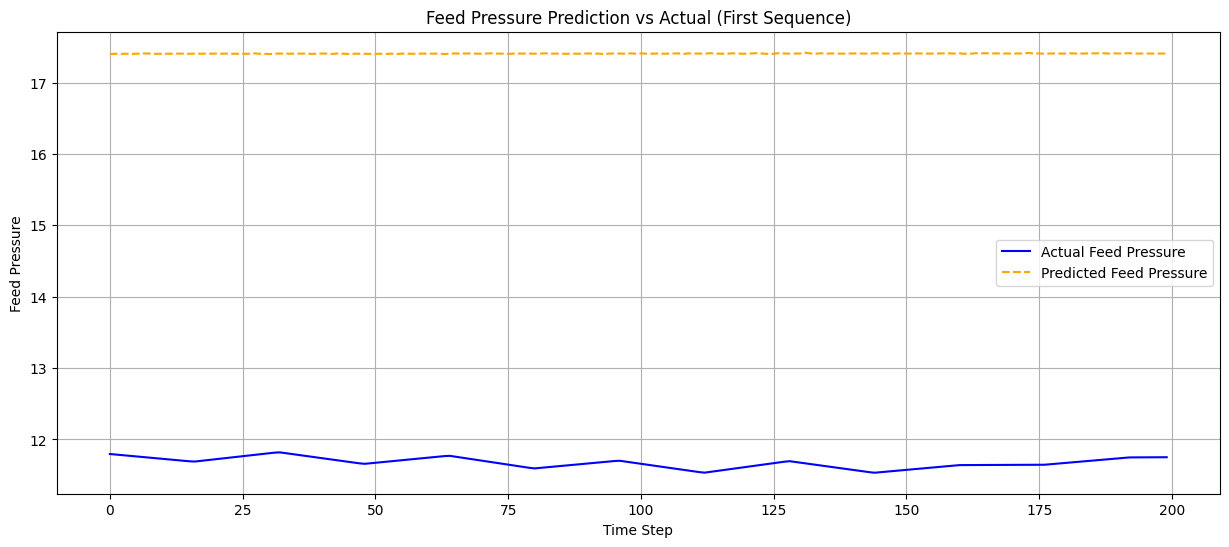

In [111]:
import matplotlib.pyplot as plt

# 예측과 실제 값을 비교하는 그래프 생성
plt.figure(figsize=(15, 6))

# 선택된 예측 값과 실제 값 중 첫 번째 시퀀스(시각적으로 잘 보이기 위해 첫 시퀀스만 표시)
time_axis = range(len(selected_predictions[0]))

plt.plot(time_axis, actuals[0], label="Actual Feed Pressure", color="blue", linewidth=1.5)
plt.plot(time_axis, selected_predictions[0], label="Predicted Feed Pressure", color="orange", linewidth=1.5, linestyle="--")

plt.xlabel("Time Step")
plt.ylabel("Feed Pressure")
plt.title("Feed Pressure Prediction vs Actual (First Sequence)")
plt.legend()
plt.grid(True)
plt.show()
